Importing the necessary packages

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
XRay_Directory = '/content/drive/My Drive/projects/Covid Xray/Dataset'

In [ ]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

Data augmentation is used to increase the diversity of data.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = image_generator.flow_from_directory(
    batch_size = 4, 
    directory= XRay_Directory, 
    shuffle= True, 
    target_size=(256,256), 
    class_mode = 'categorical', 
    subset="training")

Found 428 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory= XRay_Directory, 
    shuffle= True, 
    target_size=(256,256), 
    class_mode = 'categorical', 
    subset="validation")

Found 104 images belonging to 4 classes.


In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(4, 256, 256, 3)

In [ ]:
train_labels.shape

(4, 4)

Mapping the categories

In [ ]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

Visualizing the dataset

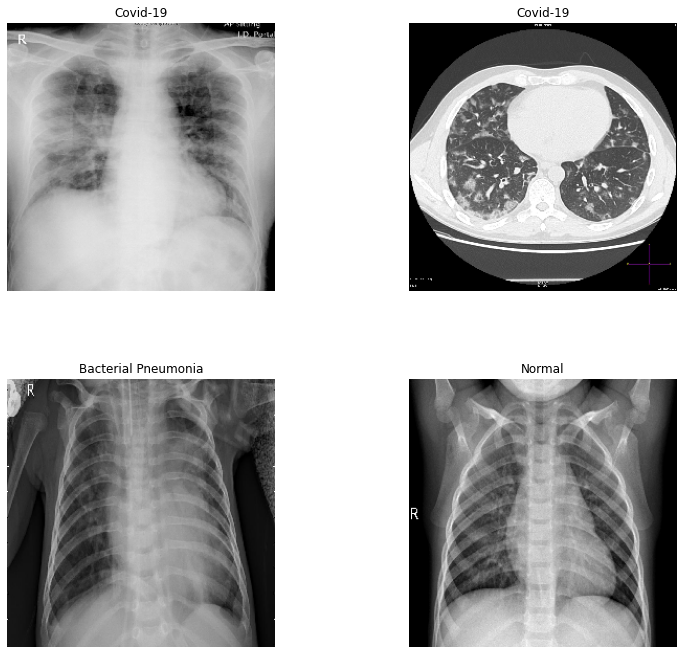

In [ ]:
# Create a grid of 36 images along with their corresponding labels
L = 2
W = 2

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

Using ResNet50 for transfer learning

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#freezing the model layer for training purpose

for layer in basemodel.layers[:-10]:
  layer.trainable = False

In [ ]:
mod = basemodel.output
mod = AveragePooling2D(pool_size = (4,4))(mod)
mod = Flatten(name= 'flatten')(mod)
mod = Dense(1024, activation = "relu")(mod)
mod = Dropout(0.3)(mod)
mod = Dense(512, activation =  "relu")(mod)
mod = Dropout(0.2)(mod)
mod = Dense(256, activation =  "relu")(mod)
mod = Dropout(0.1)(mod)
mod = Dense(4, activation = 'softmax')(mod)

model = Model(inputs = basemodel.input, outputs = mod)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-4), metrics= ["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/projects/Covid Xray/model.h5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 1.4778 - accuracy: 0.3341
Epoch 00001: val_loss improved from inf to 1.25396, saving model to /content/drive/My Drive/projects/Covid Xray/model.h5
107/107 [==============================] - 148s 1s/step - loss: 1.4778 - accuracy: 0.3341 - val_loss: 1.2540 - val_accuracy: 0.4519
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 1.1405 - accuracy: 0.4883
Epoch 00002: val_loss improved from 1.25396 to 1.12397, saving model to /content/drive/My Drive/projects/Covid Xray/model.h5
107/107 [==============================] - 143s 1s/step - loss: 1.1405 - accuracy: 0.4883 - val_loss: 1.1240 - val_accuracy: 0.4808
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.6051
Epoch 00003: val_loss improved from 1.12397 to 1.02314, saving model to /content/drive/My Drive/projects/Covid Xray/model.h5
107/107 [==============================] - 142s 1s/step - loss: 0.9329 - accu

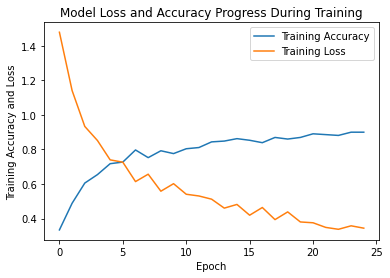

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

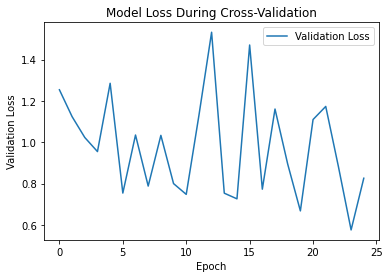

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

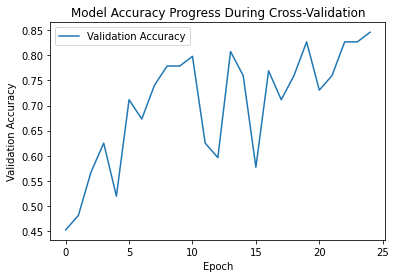

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [ ]:
test_directory = '/content/drive/My Drive/projects/Covid Xray/Test'

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 [==============================] - 8s 750ms/step - loss: 1.5733 - accuracy: 0.7000
Accuracy Test : 0.699999988079071


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.675


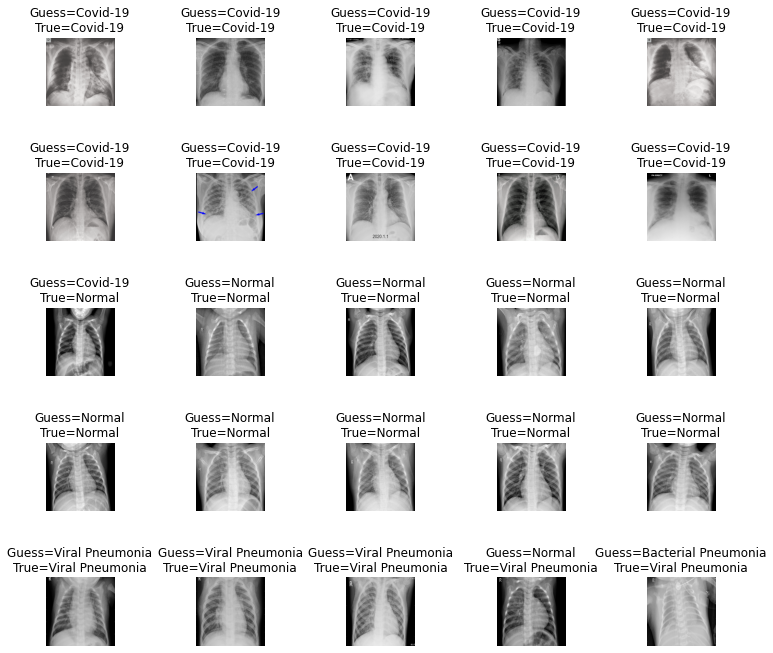

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.64      0.90      0.75        10
           2       0.71      0.50      0.59        10
           3       0.75      0.30      0.43        10

    accuracy                           0.68        40
   macro avg       0.69      0.67      0.64        40
weighted avg       0.69      0.68      0.64        40



Text(0.5, 1.0, 'Confusion_matrix')

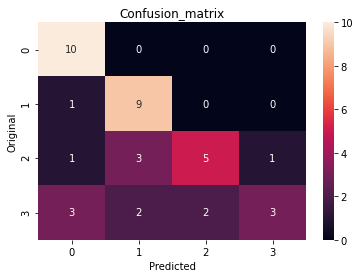

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')